## **Going Deeper 4. CutMix or Mixup Comparison Experiment**

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
# GPU 환경 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# 데이터셋을 train, test로 분류하여 로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

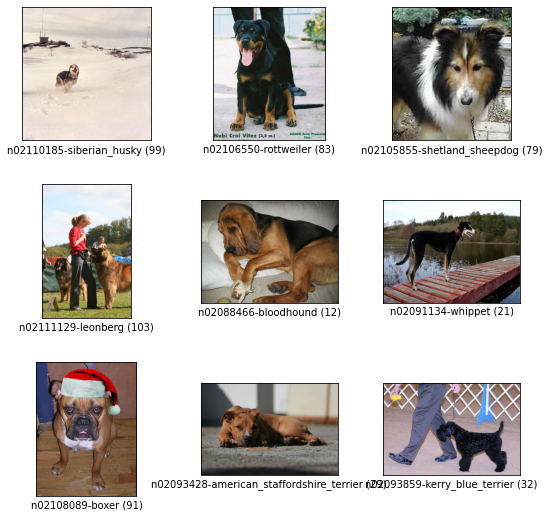

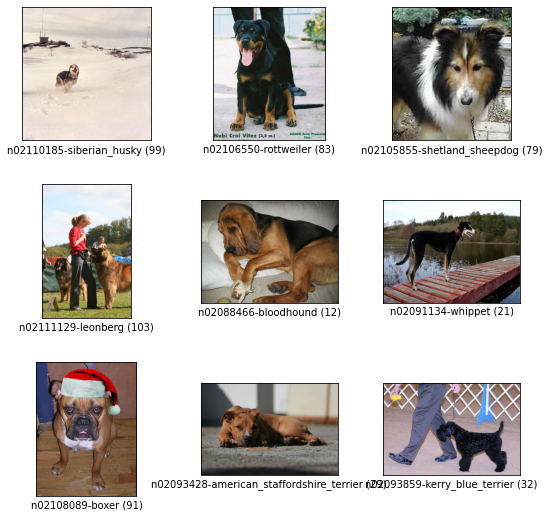

In [ ]:
# 다운로드한 데이터 확인
tfds.show_examples(ds_train, ds_info)

In [ ]:
# 입력받은 이미지를 0~1 사이의 float32로 normalize
# (224, 224) 사이즈로 resize
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
# "flip"의 경우 좌우 대칭
# "brightness"를 조절하여 다양한 환경에서 얻어진 이미지에 대응
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [ ]:
def add_gaussian_noise(image):
    # image must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=(50)/(255), dtype=tf.float32)
        noise_img = image + noise
        noise_img = tf.clip_by_value(noise_img, 0, 1)
    return noise_img

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = add_gaussian_noise(image)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [ ]:
# 원본 데이터셋에 다양한 형태의 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    # is_test : 테스트 데이터셋인지 아닌지 확인
    # with_aug : augmentation의 적용여부 결정
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용 (normalize, resize)
        num_parallel_calls=2
    )
    if not is_test and with_aug:  # 테스트셋이 아니고 with_aug 적용하고자 함
        ds = ds.map(
            augment,       # augment 함수 적용 (flip, brightness)
            num_parallel_calls=2    # map(num_parallel_calls)를 사용하면 여러 개의 스레드로 나누어서 속도를 높여 처리 가능
        )
    ds = ds.batch(batch_size)
    if not is_test:  # 테스트셋이 아니라면 
        ds = ds.repeat()  #####
        ds = ds.shuffle(200)  #####
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  #####
    return ds

In [ ]:
ds_example_test = apply_normalize_on_dataset(ds_train, with_aug=False)

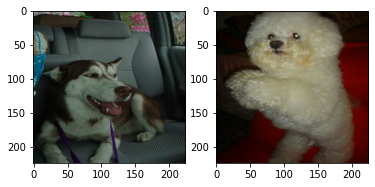

In [ ]:
# 배치 내의 이미지를 두 개 골라 섞어준다. 
# 데이터셋에서 이미지 2개를 가져온다. 
for i, (image, label) in enumerate(ds_example_test.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [ ]:
# 첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, 
# a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
# 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    # 바탕 이미지(a)의 사이즈
    image_size_x = image_a.shape[1]  # 가로
    image_size_y = image_a.shape[0]  # 세로
    
    # get center of box
    # tf.random.uniform([], 0, image_size_x) : 0 ~ image_size_x까지 숫자를 랜덤하게 뽑아 배열을 만든다.
    # 배열 부분이 []인 경우 범위 내에서 숫자 하나만 뽑아낸다.
    # tf.cast() : tf.random.uniform()에서 만들어진 배열을 tf.int32 타입으로 변환
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    # tf.random.uniform([], 0, 1) : 0~1 사이 랜덤한 숫자 하나를 뽑아낸다.
    # 1-tf.random.uniform([], 0, 1) : 1 보다는 작은 실수 
    # tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32) : 제곱근을 구한다. 위에서 나온 값보다 더 작은 값이 반환된다.
    # 위에서 구한 값을 image_size_x에 곱한 후 해당 값을 tf.int32 타입으로 변환
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(84, shape=(), dtype=int32) tf.Tensor(194, shape=(), dtype=int32)
y :  tf.Tensor(70, shape=(), dtype=int32) tf.Tensor(219, shape=(), dtype=int32)


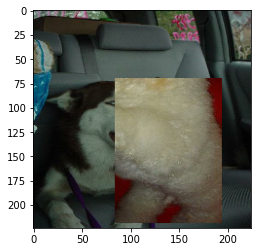

In [ ]:
# 바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 
# 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :]  # image_a의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :]  # image_a의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)  # middle = image_a 왼쪽 바깥 영역 + image_b 안쪽 영역 + image_a 오른쪽 바깥 영역
    top = image_a[0:y_min, :, :]  # image_a의 위쪽
    bottom = image_a[y_max:image_size_y, :, :]  # image_a의 아래쪽
    mixed_img = tf.concat([top, middle, bottom],axis=0)  # 결과적으로는 image_a가 바탕, image_b의 잘린 부분이 image_a에 삽입
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [ ]:
# 라벨 섞기
# CutMix에서는 면적에 비례해서 라벨을 섞어준다.
# 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더한다.
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)  # 삽입된 이미지의 면적
    total_area = image_size_x*image_size_y   # 바탕 이미지의 면적
    ratio = tf.cast(mixed_area/total_area, tf.float32)  # 바탕 이미지(a) 면적에서 삽입된 이미지(b)의 면적 비율

    if len(label_a.shape)==0:  # 라벨이 있다면
        label_a = tf.one_hot(label_a, num_classes)  # 라벨에 onehot encoding 적용
    if len(label_b.shape)==0:  # 라벨이 있다면
        label_b = tf.one_hot(label_b, num_classes)  # 라벨에 onehot encoding 적용
    mixed_label = (1-ratio)*label_a + ratio*label_b  # 라벨 또한 이미지의 면적 비율만큼 섞는다.
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

In [ ]:
# 위에서 구현한 두 함수 mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size): # batch_size만큼 반복
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))  # mix_2_images() 적용 
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))  # mix_2_label() 적용

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [ ]:
num_classes = ds_info.features["label"].num_classes

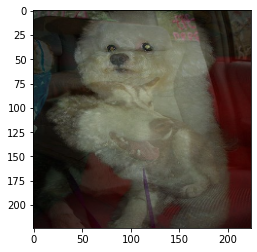

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.3781551
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)  # 0~1 사이 랜덤한 숫자 하나를 뽑아낸다.
    
    if len(label_a.shape)==0:  # 라벨이 있다면 
        label_a = tf.one_hot(label_a, num_classes)  # 라벨에 onehot encoding 적용
    if len(label_b.shape)==0:  # 라벨이 있다면 
        label_b = tf.one_hot(label_b, num_classes)  # 라벨에 onehot encoding 적용
    mixed_image= (1-ratio)*image_a + ratio*image_b  # 이미지를 일정 비율로 섞는다.
    mixed_label = (1-ratio)*label_a + ratio*label_b  # 라벨도 동일하게 섞는다.
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [ ]:
# 위에서 구현한 함수를 활용하여 "배치 단위"의 mixup() 함수를 구현
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):  # barch_size만큼 반복한다.
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)  # 앞에서 구현한 함수 적용
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    # tf.reshape(tensor, shape, name=None)
    # tf.stack() : 리스트 `mixed_imgs`, `mixed_labels`에 담긴 텐서들을 쌓아올린다.
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))  
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [ ]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

# CutMix와 Mixup을 적용할 수 있도록 변경한 apply_normalize_on_dataset()
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    # and 연산자 앞과 뒤 조건이 모두 True여야, if문이 실행된다.
    if not is_test and with_aug:  # 테스트셋이 아니고 with_aug를 적용하고자 한다. 
        ds = ds.map(
            augment  # augment 적용
        )
    ds = ds.batch(batch_size)  # Cutmix 적용하기 전 batch() 실행
    if not is_test and with_cutmix:  # 테스트셋이 아니고 with_cutmix를 적용하고자 한다.
        ds = ds.map(
            cutmix,  # cutmix 적용
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:  # 테스트셋이 아니고 with_mixup을 적용하고자 한다.
        ds = ds.map(
            mixup,  # mixup 적용
            num_parallel_calls=2
        )
    else:  # 테스트셋이라면 onehot encoding 수행
        ds = ds.map(
            onehot, 
            num_parallel_calls=2
        )
    if not is_test:  # 테스트셋이 아니라면,
        ds = ds.repeat()  ######
        ds = ds.shuffle(200)  ######
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  ######
    return ds

In [ ]:
# apply_normalize_on_dataset((ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [ ]:
# 1. Augmentation 적용하지 않은 데이터셋으로 학습시킬 ResNet
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

In [ ]:
# 2. 기본 Augmentation을 적용한 데이터셋으로 학습시킬 ResNet
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

In [ ]:
# 3. CutMix만 적용한 데이터셋으로 학습시킬 ResNet
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

In [ ]:
# 4. Mixup만 적용한 데이터셋으로 학습시킬 ResNet
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

In [ ]:
# 5. 기본 Augmentation + Cutmix를 적용한 데이터셋으로 학습시킬 ResNet
resnet50_aug_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

In [ ]:
# 6. 기본 Augmentation + Mixup를 적용한 데이터셋으로 학습시킬 ResNet
resnet50_aug_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

tf.random.set_seed(2022)

# 1. Augmentation 적용하지 않은 데이터셋 학습 모델
resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

# 2. 기본 Augmentation을 적용한 데이터셋 학습 모델
resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

# 3. CutMix만 적용한 데이터셋 학습 모델
resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

# 4. Mixup만 적용한 데이터셋 학습 모델
resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

# 5. 기본 Augmentation + Cutmix를 적용한 데이터셋 학습 모델
resnet50_aug_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

# 6. 기본 Augmentation + Mixup를 적용한 데이터셋 학습 모델
resnet50_aug_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# 1. Augmentation 적용하지 않은 데이터셋 학습
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, # Augmentation 적용하지 않은 데이터셋
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 203ms/step - loss: 2.2203 - accuracy: 0.4415 - top_k_categorical_accuracy: 0.7466 - val_loss: 3.5345 - val_accuracy: 0.1761 - val_top_k_categorical_accuracy: 0.4513
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 0.7559 - accuracy: 0.7911 - top_k_categorical_accuracy: 0.9680 - val_loss: 1.0803 - val_accuracy: 0.6866 - val_top_k_categorical_accuracy: 0.9355
Epoch 3/20
750/750 [==============================] - 153s 205ms/step - loss: 0.2497 - accuracy: 0.9465 - top_k_categorical_accuracy: 0.9961 - val_loss: 0.9419 - val_accuracy: 0.7243 - val_top_k_categorical_accuracy: 0.9488
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0603 - accuracy: 0.9948 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.9044 - val_accuracy: 0.7420 - val_top_k_categorical_accuracy: 0.9522
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0229 - accuracy: 0.9989 

In [ ]:
# 2. 기본 Augmentation을 적용한 데이터셋 학습
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, # 기본 Augmentation을 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 170s 205ms/step - loss: 3.1080 - accuracy: 0.2627 - top_k_categorical_accuracy: 0.5456 - val_loss: 5.1596 - val_accuracy: 0.0117 - val_top_k_categorical_accuracy: 0.0532
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 1.7506 - accuracy: 0.5163 - top_k_categorical_accuracy: 0.8414 - val_loss: 2.3870 - val_accuracy: 0.3800 - val_top_k_categorical_accuracy: 0.7236
Epoch 3/20
750/750 [==============================] - 153s 205ms/step - loss: 1.2246 - accuracy: 0.6580 - top_k_categorical_accuracy: 0.9114 - val_loss: 2.2421 - val_accuracy: 0.4272 - val_top_k_categorical_accuracy: 0.7682
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.8378 - accuracy: 0.7641 - top_k_categorical_accuracy: 0.9567 - val_loss: 1.9795 - val_accuracy: 0.4831 - val_top_k_categorical_accuracy: 0.8145
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 0.5746 - accuracy: 0.8423 

In [ ]:
# 3. CutMix만 적용한 데이터셋 학습
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix, # CutMix만 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
# 4. Mixup만 적용한 데이터셋 학습
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, # Mixup만 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 207ms/step - loss: 3.6983 - accuracy: 0.2517 - top_k_categorical_accuracy: 0.5092 - val_loss: 4.2829 - val_accuracy: 0.0766 - val_top_k_categorical_accuracy: 0.2561
Epoch 2/20
750/750 [==============================] - 154s 206ms/step - loss: 2.8486 - accuracy: 0.4873 - top_k_categorical_accuracy: 0.7747 - val_loss: 1.5727 - val_accuracy: 0.5569 - val_top_k_categorical_accuracy: 0.8760
Epoch 3/20
750/750 [==============================] - 154s 206ms/step - loss: 2.5665 - accuracy: 0.5908 - top_k_categorical_accuracy: 0.8307 - val_loss: 1.3636 - val_accuracy: 0.6223 - val_top_k_categorical_accuracy: 0.8993
Epoch 4/20
750/750 [==============================] - 154s 206ms/step - loss: 2.3830 - accuracy: 0.6539 - top_k_categorical_accuracy: 0.8648 - val_loss: 1.6028 - val_accuracy: 0.5711 - val_top_k_categorical_accuracy: 0.8656
Epoch 5/20
750/750 [==============================] - 154s 206ms/step - loss: 2.2308 - accuracy: 0.7209 

In [ ]:
# 5. 기본 Augmentation + Cutmix를 적용한 데이터셋 학습
history_resnet50_aug_cutmix = resnet50_aug_cutmix.fit(
    ds_train_aug_cutmix, # Mixup만 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
# 6. 기본 Augmentation + Mixup를 적용한 데이터셋 학습
history_resnet50_aug_mixup = resnet50_aug_mixup.fit(
    ds_train_aug_mixup, # Mixup만 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

### 훈련과정 시각화

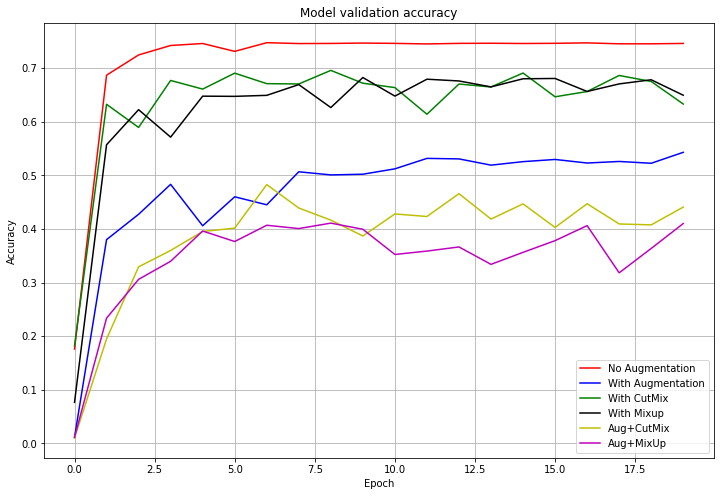

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup', 'Aug+CutMix', 'Aug+MixUp'], loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# 조금 더 확대
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

In [ ]:
import pandas as pd

# val_accuracy
acc_data = {'No Augmentation': history_resnet50_no_aug.history['val_accuracy'], 
            'With Augmentation': history_resnet50_aug.history['val_accuracy'], 
            'With CutMix': history_resnet50_cutmix.history['val_accuracy'], 
            'With Mixup': history_resnet50_mixup.history['val_accuracy'],
            'Aug+CutMix': history_resnet50_aug_cutmix.history['val_accuracy'],
            'Aug+MixUp': history_resnet50_aug_mixup.history['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df

In [ ]:
acc_df.describe()

,No Augmentation,With Augmentation,With CutMix,With Mixup,Aug+CutMix,Aug+MixUp
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.712407,0.469181,0.636929,0.621496,0.385232,0.346240
std,0.127009,0.117082,0.110403,0.132778,0.106945,0.090033
min,0.176073,0.011660,0.181903,0.076609,0.010145,0.011544
25%,0.744141,0.456157,0.642957,0.641937,0.393074,0.338240
50%,0.745686,0.509270,0.667386,0.652752,0.412838,0.364972
75%,0.745948,0.525507,0.675373,0.676393,0.439424,0.399691
max,0.747202,0.542794,0.695546,0.682253,0.482626,0.410798


In [ ]:
# val_top5 accuracy
topkacc_data = {'No Augmentation': history_resnet50_no_aug.history['val_top_k_categorical_accuracy'], 
            'With Augmentation': history_resnet50_aug.history['val_top_k_categorical_accuracy'], 
            'With CutMix': history_resnet50_cutmix.history['val_top_k_categorical_accuracy'], 
            'With Mixup': history_resnet50_mixup.history['val_top_k_categorical_accuracy'],
            'Aug+CutMix': history_resnet50_aug_cutmix.history['val_top_k_categorical_accuracy'],
            'Aug+MixUp': history_resnet50_aug_mixup.history['val_top_k_categorical_accuracy']}
topkacc_data = pd.DataFrame(topkacc_data)
topkacc_data

,No Augmentation,With Augmentation,With CutMix,With Mixup,Aug+CutMix,Aug+MixUp
0,0.451259,0.053172,0.424673,0.256063,0.049557,0.058302
1,0.935518,0.723647,0.911031,0.876049,0.471199,0.552938
2,0.948811,0.768190,0.878148,0.899254,0.667794,0.637010
3,0.952192,0.814482,0.922808,0.865555,0.711404,0.659282
4,0.952892,0.737057,0.921992,0.909865,0.732043,0.717584
5,0.943797,0.783815,0.929921,0.906833,0.731110,0.719100
6,0.950327,0.774720,0.916511,0.907649,0.799790,0.743587
7,0.950093,0.817048,0.918377,0.914412,0.755830,0.723647
8,0.948927,0.813083,0.924673,0.897038,0.732276,0.728661
9,0.948927,0.807369,0.913946,0.916395,0.698811,0.715252


In [ ]:
topkacc_data.describe()

,No Augmentation,With Augmentation,With CutMix,With Mixup,Aug+CutMix,Aug+MixUp
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.923309,0.770068,0.883804,0.871974,0.686736,0.639488
std,0.111163,0.172010,0.109118,0.145599,0.163388,0.145129
min,0.451259,0.053172,0.424673,0.256063,0.049557,0.058302
25%,0.947849,0.781542,0.898612,0.898700,0.714465,0.643307
50%,0.948694,0.819380,0.911322,0.907999,0.731577,0.657766
75%,0.948956,0.829553,0.916978,0.913188,0.750000,0.715835
max,0.952892,0.842934,0.929921,0.918377,0.799790,0.743587


,No Augmentation,With Augmentation,With CutMix,With Mixup,Aug+CutMix,Aug+MixUp
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.923309,0.770068,0.883804,0.871974,0.686736,0.639488
std,0.111163,0.172010,0.109118,0.145599,0.163388,0.145129
min,0.451259,0.053172,0.424673,0.256063,0.049557,0.058302
25%,0.947849,0.781542,0.898612,0.898700,0.714465,0.643307
50%,0.948694,0.819380,0.911322,0.907999,0.731577,0.657766
75%,0.948956,0.829553,0.916978,0.913188,0.750000,0.715835
max,0.952892,0.842934,0.929921,0.918377,0.799790,0.743587
